# Import libraries

In [1]:
from typing import List
from datetime import datetime as dt

import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
%run ./utils.ipynb

# Params

In [197]:
YEAR_MONTH = 202011

MIN_LATITUDE, MAX_LATITUDE = 25, 50
MIN_LONGITUDE, MAX_LONGITUDE = -40, -10

TIMESTAMP = "2020-11-16T00:00:00"

In [198]:
### Processed params
ECMWF_DATA_FILEPATH = f"../data/ecmwf/ecmwf-{YEAR_MONTH}-surface.grib"
LAND_DATA_FILEPATH = "../data/other/land_coast_mask.nc"

# Load raw data

In [199]:
def load_and_filter_data():
    # Load ECMWF data
    ecmwf_data = xr.open_dataset(ECMWF_DATA_FILEPATH, engine='cfgrib')
    ecmwf_data = ecmwf_data.rename({
        "u10": "u_wind",
        "v10": "v_wind",
        "t2m": "temperature",
        "sp": "pressure",
        "tcc": "cloud_cover",
    }).sortby(["time", "latitude", "longitude"])
    ecmwf_data = ecmwf_data.sel(
        time=slice(TIMESTAMP, TIMESTAMP),
        longitude=slice(MIN_LONGITUDE, MAX_LONGITUDE),
        latitude=slice(MIN_LATITUDE, MAX_LATITUDE),
    ).mean("time")
    
    # Load land & coast data
    land_coast_data = xr.open_dataset(LAND_DATA_FILEPATH)
    land_coast_data = land_coast_data.sel(
        longitude=slice(MIN_LONGITUDE, MAX_LONGITUDE),
        latitude=slice(MIN_LATITUDE, MAX_LATITUDE),
    )
    # Merge
    data = xr.merge([ecmwf_data, land_coast_data])
    return data

# Load ECMWF data
data = load_and_filter_data()
data = data.assign(wind_speed=lambda x: convert_ms_to_knot(np.sqrt(x.u_wind**2 + x.v_wind**2)))
data["pressure"] = data["pressure"] / 100

skipping variable: paramId==228 shortName='tp'
Traceback (most recent call last):
  File "/Users/dekergaradecerwan/Work/Trainings/Mindfuel_1221/.venv/lib/python3.8/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/dekergaradecerwan/Work/Trainings/Mindfuel_1221/.venv/lib/python3.8/site-packages/cfgrib/dataset.py", line 591, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1604188800, 1604210400, 1604232000, 1604253600, 1604275200,
       1604296800, 1604318400, 1604340000, 1604361600, 1604383200,
       1604404800, 1604426400, 1604448000, 1604469600, 1604491200,
       1604512800, 1604534400, 1604556000, 1604577600, 1604599200,
       1604620800, 1604642400, 1604664000, 1604685600, 1604707200,
       1604728800, 1604750400, 1604772000, 1604793600, 1604815200,
       1604836800, 160485840

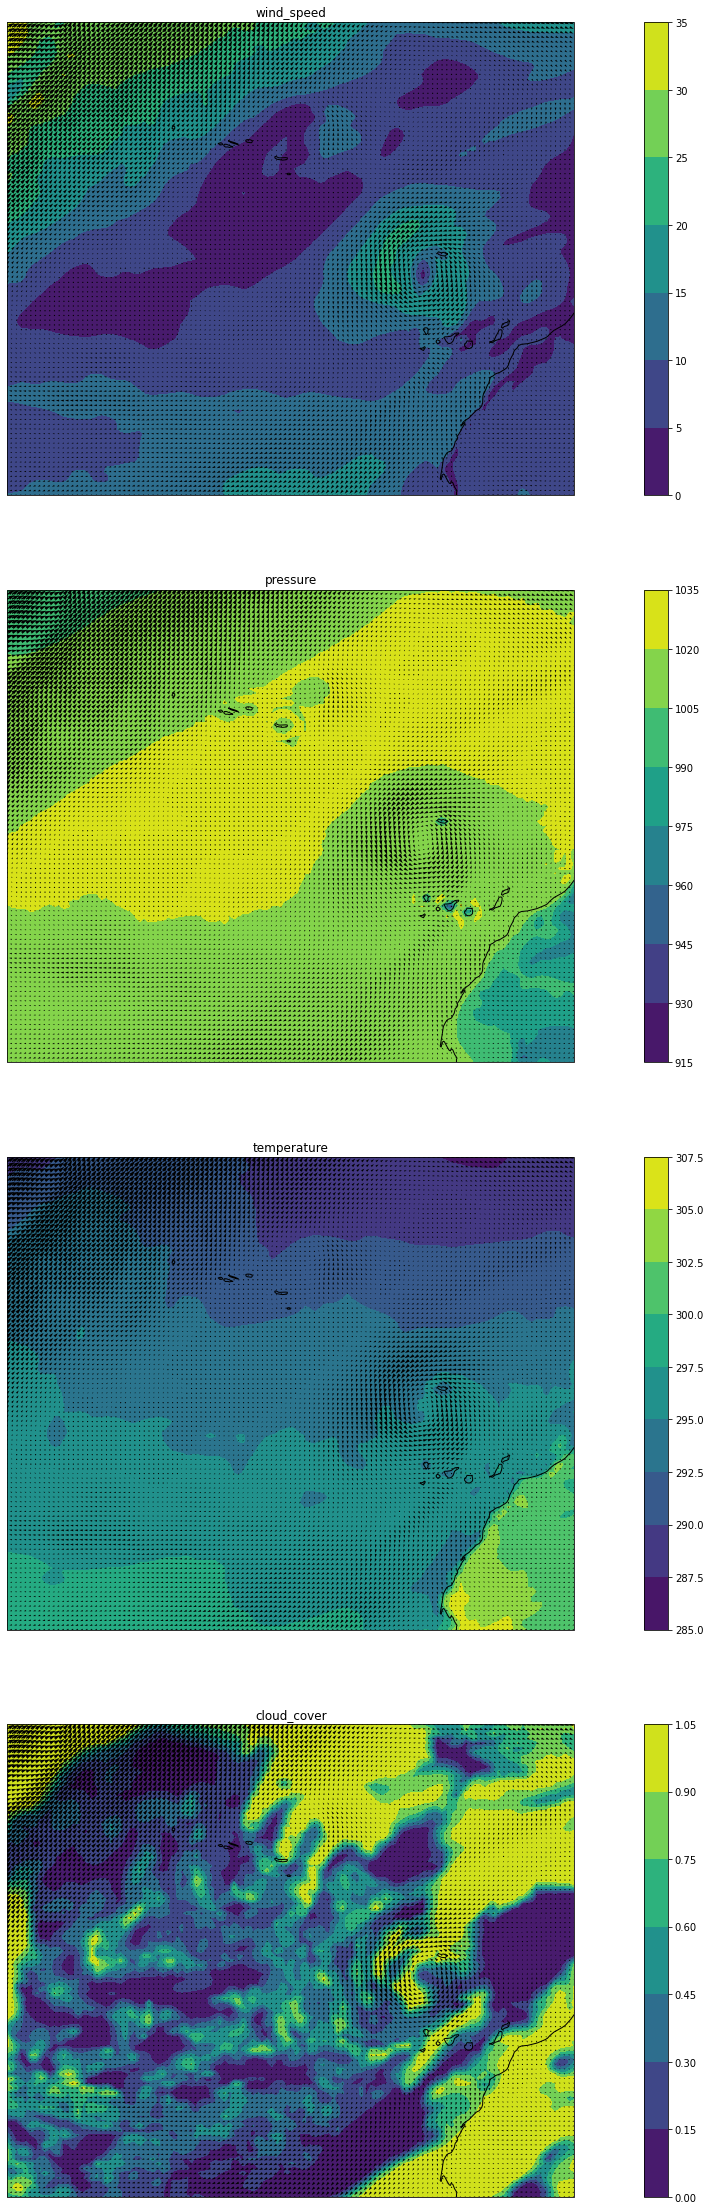

In [11]:
PLOT = True

if PLOT:
    fig = plt.figure(figsize=(25, 40))
    for i, variable_name in enumerate(["wind_speed", "pressure", "temperature", "cloud_cover"]):
      # Add subplot
        ax = fig.add_subplot(4, 1, i+1, projection=ccrs.PlateCarree())
        plt.contourf(data["longitude"], data["latitude"], data[variable_name], transform=ccrs.PlateCarree())
        ax.quiver(data["longitude"], data["latitude"], data["u_wind"], data["v_wind"])
        ax.coastlines()
        plt.colorbar()
        plt.title(variable_name)
    plt.show()

In [223]:
def plot_pressure_and_land(data, pressure_mask, no_land_mask):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.title("Low pressure")
    plt.pcolormesh(data["longitude"], data["latitude"], pressure_mask, shading='nearest', cmap=plt.cm.get_cmap('coolwarm'))
    plt.colorbar()
    plt.quiver(data["longitude"], data["latitude"], data["u_wind"], data["v_wind"])
    plt.subplot(1, 2, 2)
    plt.title("Not Land or Coast")
    plt.pcolormesh(data["longitude"], data["latitude"], no_land_mask, shading='nearest', cmap=plt.cm.get_cmap('coolwarm'))
    plt.colorbar()
    plt.quiver(data["longitude"], data["latitude"], data["u_wind"], data["v_wind"])
    
    
def plt_rot_div_mask(data, pressure_mask, no_land_mask):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.title("Rotational mask")
    plt.pcolormesh(data["longitude"], data["latitude"], pressure_mask, shading='nearest', cmap=plt.cm.get_cmap('coolwarm'))
    plt.colorbar()
    plt.quiver(data["longitude"], data["latitude"], data["u_wind"], data["v_wind"])
    plt.subplot(1, 2, 2)
    plt.title("Div mask")
    plt.pcolormesh(data["longitude"], data["latitude"], no_land_mask, shading='nearest', cmap=plt.cm.get_cmap('coolwarm'))
    plt.colorbar()
    plt.quiver(data["longitude"], data["latitude"], data["u_wind"], data["v_wind"])

def get_center_candidates(data: xr.Dataset, plot: Optional[bool] = False) -> Tuple[Tuple[xr.DataArray]]:
    """
    Get center candidates
    """
    # Calculate rotational & divergence
    u_norm, v_norm = normalize_vectors(data["u_wind"], data["v_wind"])
    rot_wind = calculate_rotational2d(u_norm, v_norm)
    div_wind = calculate_divergence2d(u_norm, v_norm)
    
    # Get conditions to be a candidate
    pressure_condition = data["pressure"] <= 1015  # Low pressure
    no_land_coast_condition = data["land_mask"] + data["coast_mask"] == 0  # No land & coast (for interferences)
    rotation_condition = rot_wind >= 1  # Rotational potential
    divergence_condition = np.abs(div_wind) <= 0.1   # Negative divergence (really ?)
    condidates_condition = (
        pressure_condition
        & no_land_coast_condition
        & rotation_condition  
        & divergence_condition
    )
    
    # Identify candidates
    latitude_idx, longitude_idx = np.where(condidates_condition)
    lon_candidates, lat_candidates = data["longitude"][longitude_idx], data["latitude"][latitude_idx]
    associated_rotational = rot_wind[condidates_condition]
    
    # Plot
    if plot:
        plot_rotational_and_divergence(data["longitude"], data["latitude"], rot_wind, div_wind)
        plt_rot_div_mask(data, rotation_condition, divergence_condition)
        plot_pressure_and_land(data, pressure_condition, no_land_coast_condition)
    return tuple(zip(lon_candidates, lat_candidates, associated_rotational))


def get_centers_from_candidates(candidates: Tuple[Tuple[np.ndarray]], deg_threshold: float) -> Tuple[Tuple[np.ndarray]]:
    """
    Find centers among candidates
    """
    if len(candidates) == 0:
        return tuple()
    lon_centers, lat_centers = [], []
    lon_to_avg, lat_to_avg, tmp_rot = [], [], []
    prev_lon, prev_lat = candidates[0][0], candidates[0][1]
    for current_lon, current_lat, current_rot in candidates:
        if np.abs(current_lon - prev_lon) <= deg_threshold and np.abs(current_lat - prev_lat) <= deg_threshold:
            lon_to_avg.append(current_lon)
            lat_to_avg.append(current_lat)
            tmp_rot.append(current_rot)
        else:
            lon_centers.append(lon_to_avg[np.argmax(np.abs(tmp_rot))])
            lat_centers.append(lat_to_avg[np.argmax(np.abs(tmp_rot))])
            lon_to_avg, lat_to_avg, tmp_rot = [current_lon], [current_lat], [current_rot]
        prev_lon, prev_lat = current_lon, current_lat
    lon_centers.append(lon_to_avg[np.argmax(np.abs(tmp_rot))])
    lat_centers.append(lat_to_avg[np.argmax(np.abs(tmp_rot))])
    return tuple(zip(lon_centers, lat_centers))
    

def identify_vortexes_center(data: xr.Dataset, threshold: Optional[float] = 5, plot: Optional[bool] = False) -> List[np.ndarray]:
    """
    From meshgrid and wind, identify vortex centers
    """
    # Identify potential candidates
    candidates = get_center_candidates(data, plot=plot)
    # Get centers from candidates
    centers = get_centers_from_candidates(candidates, deg_threshold=threshold)
    return centers


In [224]:
DATE = "2020-11-15"
HOUR = "12"
TIMESTAMP = f"{DATE}T{HOUR}:00:00"
tmp_data = data.sel(time=slice(TIMESTAMP, TIMESTAMP)).mean("time")

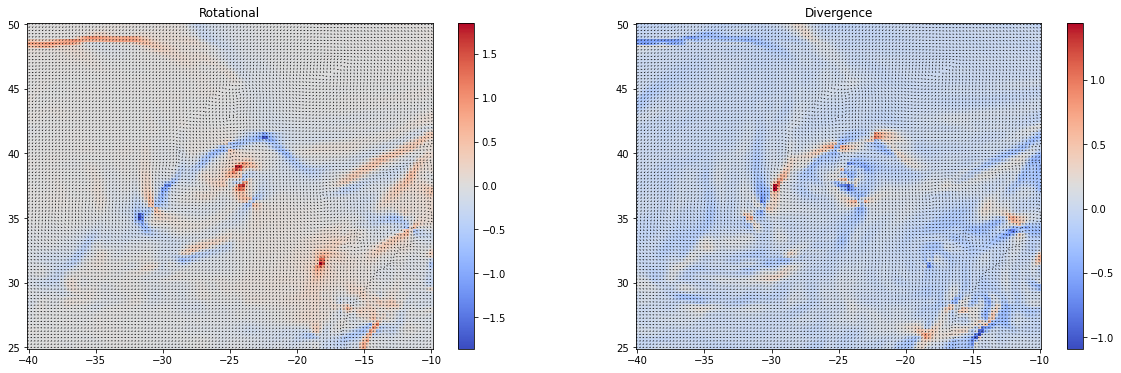

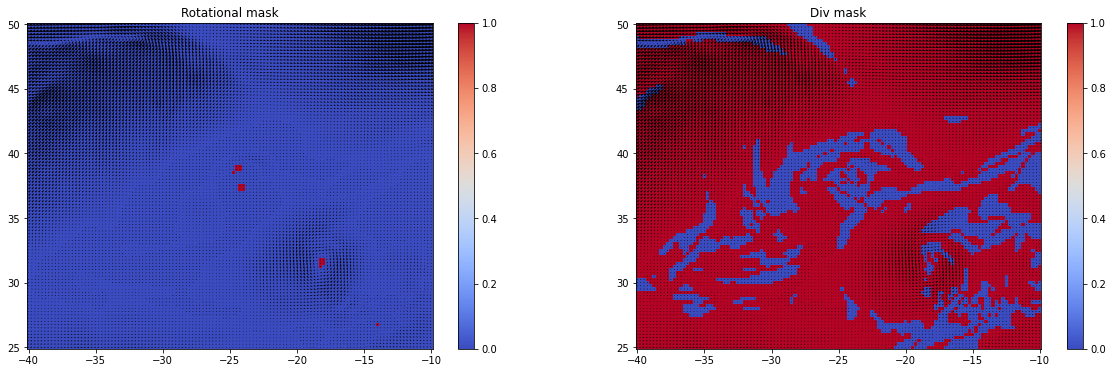

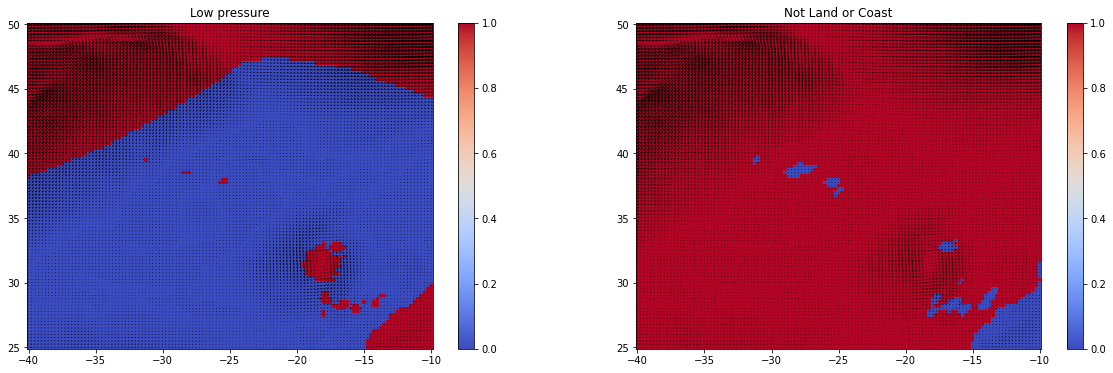

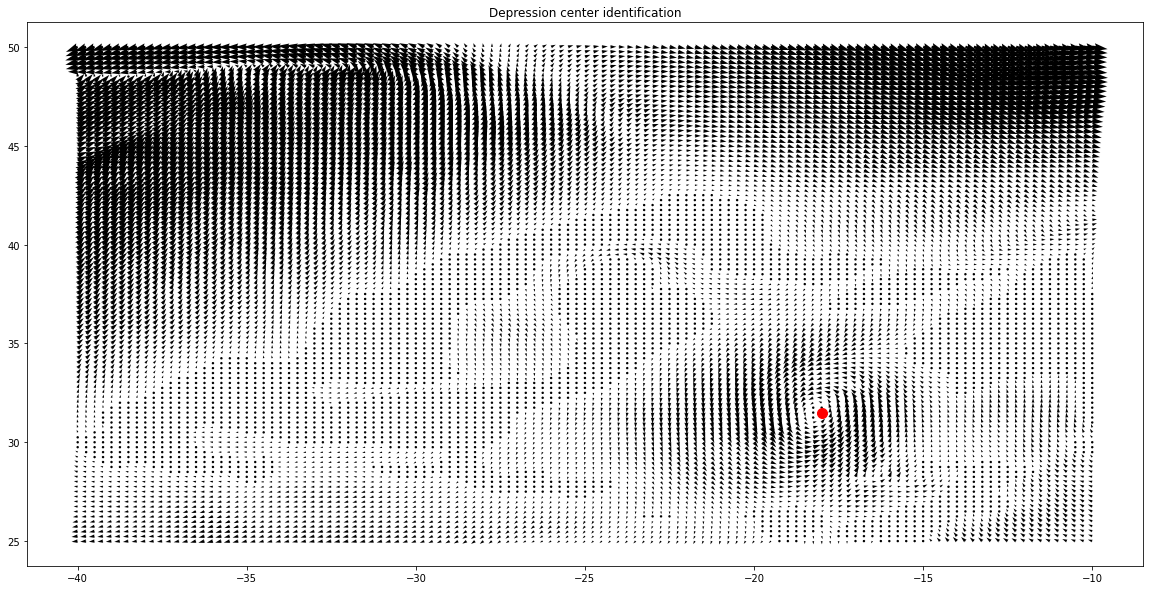

In [225]:
# Identify centers
centers = identify_vortexes_center(tmp_data, threshold=5, plot=True)

lon_centers = [center[0] for center in centers] if len(centers) > 0 else []
lat_centers = [center[1] for center in centers] if len(centers) > 0 else []

# Plot
plt.figure(figsize=(20, 10))
plt.quiver(tmp_data["longitude"], tmp_data["latitude"], tmp_data["u_wind"], tmp_data["v_wind"])
plt.scatter(lon_centers, lat_centers, color="red", s=100)
plt.title("Depression center identification")
plt.show()

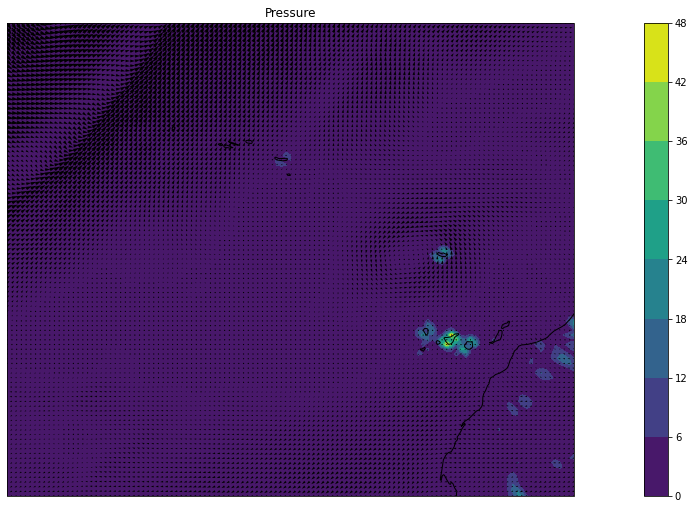

In [167]:
fig = plt.figure(figsize=(25, 40))
ax = fig.add_subplot(4, 1, i+1, projection=ccrs.PlateCarree())
# plt.contourf(tmp_data["longitude"], tmp_data["latitude"], tmp_data["pressure"], transform=ccrs.PlateCarree())
plt.contourf(
    tmp_data["longitude"], 
    tmp_data["latitude"], 
    np.abs(np.gradient(tmp_data["pressure"])[1] + np.gradient(tmp_data["pressure"])[0]),
    transform=ccrs.PlateCarree()
)
# plt.pcolormesh(tmp_data["longitude"], tmp_data["latitude"], tmp_data["pressure"], shading='nearest', cmap=plt.cm.get_cmap('coolwarm'))
ax.quiver(tmp_data["longitude"], tmp_data["latitude"], tmp_data["u_wind"], tmp_data["v_wind"])
ax.coastlines()
plt.colorbar()
plt.title("Pressure")
plt.show()